In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from software.preprocessing.video_data.DLC.Reconstruction import dlt_reconstruct
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error

In [2]:
camera_csvs = ['/Users/home/Documents/Bouchard/Brett Stuff/Arshad Labels/2019-09-17 15_3A56_3A41_cam1/CollectedData_Lab.csv', '/Users/home/Documents/Bouchard/Brett Stuff/Arshad Labels/Arshad_2019-09-17S4_cam2/CollectedData_Lab.csv', '/Users/home/Documents/Bouchard/Brett Stuff/Arshad Labels/2019-09-17 15_3A56_3A41_cam3/CollectedData_Lab.csv']
prediction_csvs = ['/Users/home/Documents/Bouchard/Brett Stuff/Arshad Labels/DLC Predictions/DLC_predictions_video_cam1_finalDLC_resnet_101_CatScanJul27shuffle5_600012.csv', '/Users/home/Documents/Bouchard/Brett Stuff/Arshad Labels/DLC Predictions/DLC_predictions_video_cam2DLC_resnet_101_CatScanJul27shuffle5_600012.csv', '/Users/home/Documents/Bouchard/Brett Stuff/Arshad Labels/DLC Predictions/DLC_predictions_video_cam3_finalDLC_resnet_101_CatScanJul27shuffle5_600012.csv']
new_prediction_csvs = ['/Users/home/Documents/Bouchard/Brett Stuff/Arshad Labels/New Predictions/video1DLC_resnet_101_LabLabelOct27shuffle1_500000.csv', '/Users/home/Documents/Bouchard/Brett Stuff/Arshad Labels/New Predictions/Cam2_resnet_101_LabLabelOct27shuffle1_500000.csv', '/Users/home/Documents/Bouchard/Brett Stuff/Arshad Labels/New Predictions/Cam3_LabLabelOct27shuffle1_500000.csv']

In [3]:
cam1_csv = np.loadtxt(camera_csvs[0], dtype=str, delimiter=",")

In [4]:
names = cam1_csv[1,1::2].copy()

In [5]:
cam1_csv_data = np.genfromtxt(camera_csvs[0], delimiter=",", skip_header=3, usecols=range(1, len(names)*2 + 1))
cam2_csv_data = np.genfromtxt(camera_csvs[1], delimiter=",", skip_header=3, usecols=range(1, len(names)*2 + 1))
cam3_csv_data = np.genfromtxt(camera_csvs[2], delimiter=",", skip_header=3, usecols=range(1, len(names)*2 + 1))

In [6]:
cam1_dlc_data = np.loadtxt(prediction_csvs[0], skiprows=3, delimiter=",")[:, 1:]
cam2_dlc_data = np.loadtxt(prediction_csvs[1], skiprows=3, delimiter=",")[:, 1:]
cam3_dlc_data = np.loadtxt(prediction_csvs[2], skiprows=3, delimiter=",")[:, 1:]

In [7]:
def process_csv(prediction_csvs):
    data_dict = {}

    cam1_dlc_data = np.loadtxt(prediction_csvs[0], skiprows=3, delimiter=",")[:, 1:]
    cam2_dlc_data = np.loadtxt(prediction_csvs[1], skiprows=3, delimiter=",")[:, 1:]
    cam3_dlc_data = np.loadtxt(prediction_csvs[2], skiprows=3, delimiter=",")[:, 1:]

    discarded = set()
    shortest_len = min(cam1_dlc_data.shape[0], cam2_dlc_data.shape[0], cam3_dlc_data.shape[0])
    for i in range(len(names)):
        labelled_idx = i * 2
        predicted_idx = i * 3
        entry_dict = {}

        cam1_labelled_x = cam1_csv_data[:shortest_len, labelled_idx].copy()
        cam1_predicted_x = cam1_dlc_data[:shortest_len, predicted_idx].copy()
        cam1_labelled_y = cam1_csv_data[:shortest_len, labelled_idx + 1].copy()
        cam1_predicted_y = cam1_dlc_data[:shortest_len, predicted_idx + 1].copy()
        cam1_predicted_prob = cam1_dlc_data[:shortest_len, predicted_idx + 2].copy()
        
        cam2_labelled_x = cam2_csv_data[:shortest_len, labelled_idx].copy()
        cam2_predicted_x = cam2_dlc_data[:shortest_len, predicted_idx].copy()
        cam2_labelled_y = cam2_csv_data[:shortest_len, labelled_idx + 1].copy()
        cam2_predicted_y = cam2_dlc_data[:shortest_len, predicted_idx + 1].copy()
        cam2_predicted_prob = cam2_dlc_data[:shortest_len, predicted_idx + 2].copy()

        cam3_labelled_x = cam3_csv_data[:shortest_len, labelled_idx].copy()
        cam3_predicted_x = cam3_dlc_data[:shortest_len, predicted_idx].copy()
        cam3_labelled_y = cam3_csv_data[:shortest_len, labelled_idx + 1].copy()
        cam3_predicted_y = cam3_dlc_data[:shortest_len, predicted_idx + 1].copy()
        cam3_predicted_prob = cam3_dlc_data[:shortest_len, predicted_idx + 2].copy()


        mask = np.isnan(cam1_labelled_x) | np.isnan(cam1_labelled_y) | np.isnan(cam2_labelled_x) | np.isnan(cam2_labelled_y) | np.isnan(cam3_labelled_x) | np.isnan(cam3_labelled_y)
        if np.sum(~mask) < 10:
            print("Not enough entries for {}, discarding".format(names[i]))
            discarded.add(names[i])
            continue
        cam1_labelled_x[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam1_labelled_x[~mask])
        cam1_labelled_y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam1_labelled_y[~mask])
        cam2_labelled_x[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam2_labelled_x[~mask])
        cam2_labelled_y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam2_labelled_y[~mask])
        cam3_labelled_x[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam3_labelled_x[~mask])
        cam3_labelled_y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam3_labelled_y[~mask])
        
        entry_dict["Camera 1"] = {}
        entry_dict["Camera 1"]["labelled_x"] = cam1_labelled_x
        entry_dict["Camera 1"]["predicted_x"] = cam1_predicted_x
        entry_dict["Camera 1"]["labelled_y"] = cam1_labelled_y
        entry_dict["Camera 1"]["predicted_y"] = cam1_predicted_y
        entry_dict["Camera 1"]["predicted_prob"] = cam1_predicted_prob
        entry_dict["Camera 1"]["max_x"] = max(np.max(entry_dict["Camera 1"]["labelled_x"]), np.max(entry_dict["Camera 1"]["predicted_x"]))
        entry_dict["Camera 1"]["max_y"] = max(np.max(entry_dict["Camera 1"]["labelled_y"]), np.max(entry_dict["Camera 1"]["predicted_y"]))
        entry_dict["Camera 1"]["min_x"] = min(np.min(entry_dict["Camera 1"]["labelled_x"]), np.min(entry_dict["Camera 1"]["predicted_x"]))
        entry_dict["Camera 1"]["min_y"] = min(np.min(entry_dict["Camera 1"]["labelled_y"]), np.min(entry_dict["Camera 1"]["predicted_y"]))

        entry_dict["Camera 2"] = {}
        entry_dict["Camera 2"]["labelled_x"] = cam2_labelled_x
        entry_dict["Camera 2"]["predicted_x"] = cam2_predicted_x
        entry_dict["Camera 2"]["labelled_y"] = cam2_labelled_y
        entry_dict["Camera 2"]["predicted_y"] = cam2_predicted_y
        entry_dict["Camera 2"]["predicted_prob"] = cam2_predicted_prob
        entry_dict["Camera 2"]["max_x"] = max(np.max(entry_dict["Camera 2"]["labelled_x"]), np.max(entry_dict["Camera 2"]["predicted_x"]))
        entry_dict["Camera 2"]["max_y"] = max(np.max(entry_dict["Camera 2"]["labelled_y"]), np.max(entry_dict["Camera 2"]["predicted_y"]))
        entry_dict["Camera 2"]["min_x"] = min(np.min(entry_dict["Camera 2"]["labelled_x"]), np.min(entry_dict["Camera 2"]["predicted_x"]))
        entry_dict["Camera 2"]["min_y"] = min(np.min(entry_dict["Camera 2"]["labelled_y"]), np.min(entry_dict["Camera 2"]["predicted_y"]))

        entry_dict["Camera 3"] = {}
        entry_dict["Camera 3"]["labelled_x"] = cam3_labelled_x
        entry_dict["Camera 3"]["predicted_x"] = cam3_predicted_x
        entry_dict["Camera 3"]["labelled_y"] = cam3_labelled_y
        entry_dict["Camera 3"]["predicted_y"] = cam3_predicted_y
        entry_dict["Camera 3"]["predicted_prob"] = cam3_predicted_prob
        entry_dict["Camera 3"]["max_x"] = max(np.max(entry_dict["Camera 3"]["labelled_x"]), np.max(entry_dict["Camera 3"]["predicted_x"]))
        entry_dict["Camera 3"]["max_y"] = max(np.max(entry_dict["Camera 3"]["labelled_y"]), np.max(entry_dict["Camera 3"]["predicted_y"]))
        entry_dict["Camera 3"]["min_x"] = min(np.min(entry_dict["Camera 3"]["labelled_x"]), np.min(entry_dict["Camera 3"]["predicted_x"]))
        entry_dict["Camera 3"]["min_y"] = min(np.min(entry_dict["Camera 3"]["labelled_y"]), np.min(entry_dict["Camera 3"]["predicted_y"]))
        data_dict[names[i]] = entry_dict
    filtered_names = [name for name in names if name not in discarded]
    data_dict["filtered_names"] = filtered_names
    thres = 0.05
    for name in filtered_names:
        for cam in ["Camera 1", "Camera 2", "Camera 3"]:
            mask = data_dict[name][cam]["predicted_prob"] < thres
            data_dict[name][cam]["interp_predicted_prob"] = data_dict[name][cam]["predicted_prob"].copy()
            data_dict[name][cam]["interp_predicted_prob"][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data_dict[name][cam]["predicted_prob"][~mask])
            data_dict[name][cam]["interp_predicted_x"] = data_dict[name][cam]["predicted_x"].copy()
            data_dict[name][cam]["interp_predicted_x"][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data_dict[name][cam]["predicted_x"][~mask])
            data_dict[name][cam]["interp_predicted_y"] = data_dict[name][cam]["predicted_y"].copy()
            data_dict[name][cam]["interp_predicted_y"][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data_dict[name][cam]["predicted_y"][~mask])
    return data_dict

In [8]:
def get_reconstructions(data_dict, dlt_coefs_file):
    dlt_coefs = np.loadtxt(dlt_coefs_file, delimiter=",")
    reconstructions = {}
    for name in data_dict["filtered_names"]:
        # read in data from DLC
        frames = data_dict[name]["Camera 1"]["labelled_x"].shape[0]
        cam_data = np.empty([frames, 6], dtype=float)
        weights = np.empty([frames, 6], dtype=float)

        cam_data[:, 0] = data_dict[name]["Camera 1"]["labelled_x"]
        cam_data[:, 1] = data_dict[name]["Camera 1"]["labelled_y"]
        cam_data[:, 2] = data_dict[name]["Camera 2"]["labelled_x"]
        cam_data[:, 3] = data_dict[name]["Camera 2"]["labelled_y"]
        cam_data[:, 4] = data_dict[name]["Camera 3"]["labelled_x"]
        cam_data[:, 5] = data_dict[name]["Camera 3"]["labelled_y"]

        xyz_labelled = dlt_reconstruct(dlt_coefs, cam_data)

        cam_data[:, 0] = data_dict[name]["Camera 1"]["predicted_x"]
        cam_data[:, 1] = data_dict[name]["Camera 1"]["predicted_y"]
        cam_data[:, 2] = data_dict[name]["Camera 2"]["predicted_x"]
        cam_data[:, 3] = data_dict[name]["Camera 2"]["predicted_y"]
        cam_data[:, 4] = data_dict[name]["Camera 3"]["predicted_x"]
        cam_data[:, 5] = data_dict[name]["Camera 3"]["predicted_y"]
        
        weights[:, 0] = data_dict[name]["Camera 1"]["predicted_prob"]
        weights[:, 1] = data_dict[name]["Camera 1"]["predicted_prob"]
        weights[:, 2] = data_dict[name]["Camera 2"]["predicted_prob"]
        weights[:, 3] = data_dict[name]["Camera 2"]["predicted_prob"]
        weights[:, 4] = data_dict[name]["Camera 3"]["predicted_prob"]
        weights[:, 5] = data_dict[name]["Camera 3"]["predicted_prob"]

        xyz_predicted_weighted = dlt_reconstruct(dlt_coefs, cam_data, weights)
        xyz_predicted_unweighted = dlt_reconstruct(dlt_coefs, cam_data)

        cam_data[:, 0] = data_dict[name]["Camera 1"]["interp_predicted_x"]
        cam_data[:, 1] = data_dict[name]["Camera 1"]["interp_predicted_y"]
        cam_data[:, 2] = data_dict[name]["Camera 2"]["interp_predicted_x"]
        cam_data[:, 3] = data_dict[name]["Camera 2"]["interp_predicted_y"]
        cam_data[:, 4] = data_dict[name]["Camera 3"]["interp_predicted_x"]
        cam_data[:, 5] = data_dict[name]["Camera 3"]["interp_predicted_y"]
        
        weights[:, 0] = data_dict[name]["Camera 1"]["interp_predicted_prob"]
        weights[:, 1] = data_dict[name]["Camera 1"]["interp_predicted_prob"]
        weights[:, 2] = data_dict[name]["Camera 2"]["interp_predicted_prob"]
        weights[:, 3] = data_dict[name]["Camera 2"]["interp_predicted_prob"]
        weights[:, 4] = data_dict[name]["Camera 3"]["interp_predicted_prob"]
        weights[:, 5] = data_dict[name]["Camera 3"]["interp_predicted_prob"]

        xyz_interp_predicted_weighted = dlt_reconstruct(dlt_coefs, cam_data, weights)
        xyz_interp_predicted_unweighted = dlt_reconstruct(dlt_coefs, cam_data)

        reconstructions[name] = {}
        reconstructions[name]["xyz_labelled"] = xyz_labelled
        reconstructions[name]["xyz_predicted_weighted"] = xyz_predicted_weighted
        reconstructions[name]["xyz_predicted_unweighted"] = xyz_predicted_unweighted
        reconstructions[name]["xyz_interp_predicted_weighted"] = xyz_interp_predicted_weighted
        reconstructions[name]["xyz_interp_predicted_unweighted"] = xyz_interp_predicted_unweighted
        reconstructions[name]["xyz_predicted_prob"] = np.mean(np.array([data_dict[name]["Camera 1"]["predicted_prob"], data_dict[name]["Camera 2"]["predicted_prob"], data_dict[name]["Camera 3"]["predicted_prob"]]), axis=0)
        reconstructions[name]["xyz_interp_predicted_prob"] = np.mean(np.array([data_dict[name]["Camera 1"]["interp_predicted_prob"], data_dict[name]["Camera 2"]["interp_predicted_prob"], data_dict[name]["Camera 3"]["interp_predicted_prob"]]), axis=0)
    return reconstructions

In [9]:
old_dlt_coefs_file = '/Users/home/Documents/Bouchard/Brett Stuff/DeepLabCutCSVs/test_dlt.csv'
dlt_coefs_file_1 = '/Users/home/Documents/Bouchard/Brett Stuff/DeepLabCutCSVs/many_pts_520_dltCoefs.csv'
dlt_coefs_file_2 = '/Users/home/Documents/Bouchard/Brett Stuff/DeepLabCutCSVs/Under2px1_dltCoefs.csv'
dlt_coefs_file_3 = '/Users/home/Documents/Bouchard/Brett Stuff/DeepLabCutCSVs/Try_1_DLCCalib_dltCoefs.csv'
old_data_dict = process_csv(prediction_csvs)
old_reconstructions = get_reconstructions(old_data_dict, old_dlt_coefs_file)
reconstructions_1 = get_reconstructions(old_data_dict, dlt_coefs_file_1)
reconstructions_2 = get_reconstructions(old_data_dict, dlt_coefs_file_2)
reconstructions_3 = get_reconstructions(old_data_dict, dlt_coefs_file_3)
# new_data_dict = process_csv(new_prediction_csvs)
# new_reconstructions = get_reconstructions(new_data_dict)

Not enough entries for Shoulder 1, discarding
Not enough entries for Fourth Base 1, discarding
Not enough entries for Shoulder 2, discarding
Not enough entries for Index Base 2, discarding
Not enough entries for Index Tip 2, discarding
Not enough entries for Middle Base 2, discarding


In [10]:
reconstructions = [old_reconstructions, reconstructions_1, reconstructions_2, reconstructions_3]
errors = []
for reconstruction in reconstructions:
    errors.append(np.array([mean_squared_error(reconstruction[name]["xyz_labelled"], reconstruction[name]["xyz_predicted_weighted"], squared=False) for name in reconstruction.keys()]))

In [12]:
errors

[array([0.00139785, 0.00307314, 0.00794301, 0.01379153, 0.01071831,
        0.01569158, 0.01568777, 0.01547204, 0.01602327, 0.01152801,
        0.01856297, 0.01590736, 0.01735754, 0.01993328, 0.02281078,
        0.02434813, 0.03456072, 0.03104685, 0.03395188, 0.03144773,
        0.0340607 ]),
 array([0.00066861, 0.00150649, 0.00382846, 0.00673987, 0.00535432,
        0.00739946, 0.00792314, 0.00696721, 0.00776206, 0.00555928,
        0.00843252, 0.00721909, 0.00870651, 0.01579958, 0.01318319,
        0.01397922, 0.01815998, 0.01655769, 0.01804713, 0.0174622 ,
        0.01909802]),
 array([0.00139785, 0.00307314, 0.00794301, 0.01379153, 0.01071831,
        0.01569158, 0.01568777, 0.01547204, 0.01602327, 0.01152801,
        0.01856297, 0.01590736, 0.01735754, 0.01993328, 0.02281078,
        0.02434813, 0.03456072, 0.03104685, 0.03395188, 0.03144773,
        0.0340607 ]),
 array([0.0007339 , 0.00171476, 0.00416794, 0.00719579, 0.00583568,
        0.00811366, 0.00873187, 0.0076825 , 0.0085

Text(0.5, 1.0, 'RMSE Distibution across Body Parts')

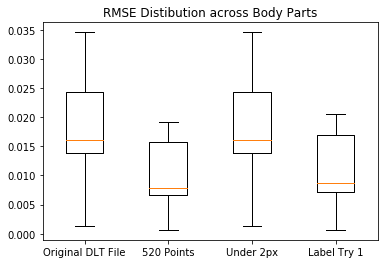

In [15]:
plt.boxplot(errors, labels=["Original DLT File", "520 Points", "Under 2px", "Label Try 1"])
plt.title("RMSE Distibution across Body Parts")